# Quantum Annealing with the Jarzynski Equality
## Masayuki Ohzeki. *Phys. Rev. Lett.* 2010.

### この論文について追実験を行い手法のメリット・デメリットを確認する.

# 要旨
　非平衡統計力学におけるJarzynski等式$\left\langle\exp(-\beta\Delta w)\right\rangle_\Gamma=Z_1/Z_0$は分配関数に関して成り立つ等式であり，本来準静的なプロトコルでしか求めることができなかった量を集合平均を用いることで有限時間のプロトコルで求めることができるものである．本研究では量子アニーリングにこの等式を導入することで，有限時間のスケジュールであっても効率よく基底状態を得ることを目的としている．
 
　ポイントは以下のようになる．
 
 - 量子アニーリングを古典の形式に合わせるためClassical-quantum mappingにより逆温度$\beta$を導入する.
 - 基底状態を次の逆温度の基底状態に変える演算子exponentiated work operator $W_\mathrm{unit.}$を導入する.
 - $W_\mathrm{unit.}$をユニタリにするためにancillaが必要である．
 - 一様な基底状態に$W_\mathrm{unit.}$を繰り返し適用することで目的のハミルトニアン$H_0$の基底状態の成分が大きくなる
 - 逆温度をある$\beta$まで変化させるとする．$\delta\beta$によって必要な$W_\mathrm{unit.}$の回数は変わるが，最終的な状態についてancilaを$\left|0\right\rangle$に射影すると$H_0$の基底を得る確率は$\delta\beta$によらず$\beta$のみで定まる．これがJarzynski等式のメリットである．
 - 実装面ではトレードオフが存在する．$\delta\beta$が大きいとancillaが$\left|1\right\rangle$になる確率が大きくなってしまう．他方，$\delta\beta$が小さいと目的の$\beta$に達するために必要な$W_\mathrm{unit.}$が増えるためより多くのancilla qubitsが必要になる．

# 準備
### テンソル積の定義

In [1]:
import numpy as np
def tp(m1, m2):
    (r1, c1) = m1.shape
    (r2, c2) = m2.shape
    
    return np.vstack([np.hstack([m1[i, j] * m2 for j in range(c1)]) for i in range(r1)])

# m_listは行列のリスト
def tensor_product(m_list):
    s = len(m_list)
    if s == 0:
        return None
    else:
        c = m_list[0]
        for i in range(1, s):
            c = tp(c, m_list[i])
    return c

### 基本的なベクトルと行列の定義

In [2]:
bra0 = np.matrix([1,0]).T#|0>
hadamard = np.matrix([[1,1],[1,-1]])/2**0.5
I = np.matrix(np.identity(2))

# 本編

### 具体的な問題を通じて本手法の有効性を確認する．
### ここではデータベース検索問題を解く．
### $N$個の基底の中からハミルトニアン$H_0$を最小にする基底を探索する．
### 簡単のために解は$\left|0\cdots0\right\rangle$とする．

In [3]:
def H0(bra):
    bra0 = np.matrix([1,0]).T
    N = int(np.log2(len(bra)))
    bra0_N = tensor_product([bra0]*N)
    return -np.dot(bra0_N.T,bra)[0,0]*0.1+0.15#適当に平行移動して正にする

## the exponentiated work operator $W_\mathrm{unit.}$を定義する．
### この演算子は古典のアニーリングにおける温度を下げる操作に対応しており，１ステップで逆温度が$\delta \beta$大きくなる．
### $W_\mathrm{unit.}$を一回作用させるごとにancilla qubitが１つ必要である．今回は$N_b$ステップ作用させるのでancillaは$N_b$qubitsであり，$W_\mathrm{unit.}$は$N+N_b$qubitsに作用する．

In [18]:
def y(bra,dbeta):
    return np.exp(-dbeta*H0(bra))

def Wunit(N,Nb,nb,dbeta):
    I = np.matrix([[1,0],[0,1]])
    Wunit = None
    for i in range(2**N):
        bra = np.zeros((2**N,1))
        bra[i] = 1#全ての基底を網羅する
        y_bra = y(bra,dbeta)
        Y = np.matrix([[y_bra**0.5,(1-y_bra)**0.5],[-(1-y_bra)**0.5,y_bra**0.5]])
        w = np.dot(bra,bra.T)
        for j in range(Nb):
            if j==nb:
                w = tp(w,Y)
            else:
                w = tp(w,I)
        if Wunit is None:
            Wunit = w
        else:
            Wunit += w
    return Wunit

# 計算

### アニーリングの初期状態として各基底が一様に混ざった状態$\left|\Psi_\mathrm{eq}(0)\right\rangle$を用意する．
### 今回は簡単のためにアダマールゲート$H$で生成する．
### $\left|\Psi_\mathrm{eq}(0)\right\rangle=(H\otimes\cdots\otimes H)(\left|0\right\rangle\otimes\cdots\otimes \left|0\right\rangle)$

In [5]:
def get_initial_state(N):
    bra0_N = tensor_product([bra0]*N)
    hadamard_N = tensor_product([hadamard]*N)
    bra_eq0 = np.dot(hadamard_N,bra0_N)
    return bra_eq0

### computational state $\left|\Psi_\mathrm{eq}(0),\phi=0\right\rangle$を生成する．
###  $\phi$は$N_b$qubitsのancillaである．

In [6]:
def get_computational_state(N,Nb):
    phi = tensor_product([bra0]*Nb)
    bra_eq0 = get_initial_state(N)
    computational_state = tensor_product([bra_eq0,phi])
    return computational_state

### $W_\mathrm{unit.}$をcomputational stateに$N_b$回適用し状態$\left|\Psi,\phi'\right\rangle$を得る．
### この状態のancilla qubitsを0で射影測定することで状態$\left|\Psi\right\rangle$を得る．
### $\left|\Psi\right\rangle$を基底測定すれば問題の解の候補を得ることができる．

In [23]:
def get_final_computational_state(N,Nb,dbeta):
    computational_state = get_computational_state(N,Nb)
    for i in range(Nb):
        computational_state = np.dot(Wunit(N=N,Nb=Nb,nb=i,dbeta=dbeta),computational_state)
    return computational_state

### 各基底を得る確率とancillaが$\left|0\right>$である確率

In [33]:
def get_probs(bra,N):
    p_tot = np.linalg.norm(bra[:N])**2
    probs = []
    for i in range(2**N):
        prob = np.abs(float(bra[i]))**2/p_tot
        probs.append(prob)
    return probs,p_tot

[0.9048374180359596, 0.09516258196404037, 0.7408182206817178, 0.2591817793182822]


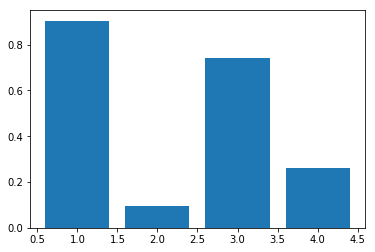

[0.9512294245007141, 0.04877057549928599, 0.04877057549928599, 0.002500520876738048]


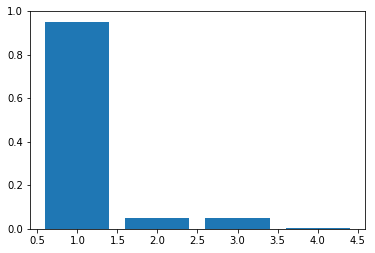

[0.9672161004820059, 0.0327838995179941, 0.0327838995179941, 0.0011112139955800175]


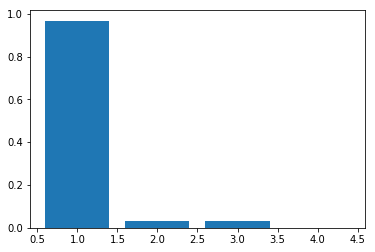

[0.9753099120283328, 0.024690087971667274, 0.024690087971667274, 0.0006250325527615062]


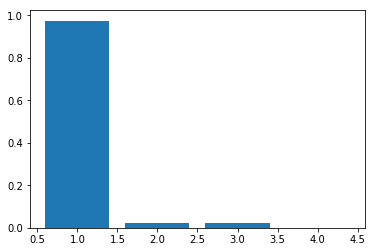

In [35]:
N = 2
beta = 1
probs_ls = []
Nb_ls = [1,2,3,4]
for Nb in Nb_ls:
    dbeta = 2/Nb
    computational_state = get_final_computational_state(N,Nb,dbeta)
    probs,p_tot = get_probs(computational_state,N)
    probs_ls.append(probs)
    
import matplotlib.pyplot as plt
for probs in probs_ls:
    print(probs)
    plt.bar(Nb_ls,probs)
    plt.show()